In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib import colors
from matplotlib import cm
from matplotlib.ticker import NullFormatter
from mpl_toolkits.mplot3d import Axes3D

from scipy import stats
from scipy.stats import multivariate_normal

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from skimage.transform import resize

import math

import seaborn as sns; sns.set()
np.random.seed(42)

In [2]:
class genere_distributions():
    nx, ny = 300, 300
    npts = 200
    
    def __init__(self, mu, sigma, angle, prob_C, x_min, x_max, y_min, y_max):
        self.mu = mu
        self.sigma = sigma
        self.angle = angle
        self.prob_C = prob_C
        self.x_min = x_min 
        self.x_max = x_max 
        self.y_min = y_min 
        self.y_max = y_max         
        
        # Calcul du nombre de points 2D dans chacun des nuages de points. Le nombre total npts est constant, 
        # mais la répartition du nombre de points dans chaque nuage dépend de la probabilité apriori de chaque
        # distribution.
        self.n = (self.npts*self.prob_C).astype(int)
        
        self.calcule_cov()
        self.genere_dataset()
        self.genere_grid()


    # Calcule les matrices de covariance
    def calcule_cov(self):
        self.n_amas = self.n.shape[0] 
        self.cov = np.zeros((2, 2, self.n_amas))
        for i in range(self.n_amas):
            # Matrice de rotation
            theta = np.radians(self.angle[i])
            c, s = np.cos(theta), np.sin(theta)
            R = np.array(((c, -s), (s, c)))        

            # Matrice de covariance avant rotation
            C = np.array([[self.sigma[i, 0]**2, 0.],[0., self.sigma[i, 1]**2]])

            # Matrice de covariance après rotation
            # new_cov = rotation_matrix @ cov @ rotation_matrix.T
            self.cov[:,:,i] = R.dot( C.dot(R.T) )  

            
    # Génère les données 2D
    def genere_dataset(self):
        X0 = np.random.multivariate_normal(self.mu[0,:], self.cov[:,:,0], self.n[0])
        y0 = np.zeros(self.n[0])
        for i in range(1, self.n_amas):
            X = np.random.multivariate_normal(self.mu[i,:], self.cov[:,:,i], self.n[i])
            X0 = np.r_[X0, X]
            y0 = np.hstack((y0, np.ones(self.n[i])*i))  
            
        self.X = X0       
        self.y = y0   
        
        
    def genere_grid(self):        
        self.xx, self.yy = np.meshgrid(np.linspace(self.x_min, self.x_max, self.nx), 
                                       np.linspace(self.y_min, self.y_max, self.ny))
        self.pos = np.dstack((self.xx, self.yy))
        

    def plot_dataset(self, discriminant, ax):

        tp = (self.y == self.y_pred)  # True Positive

        if (self.n_amas==2):           
            tp0, tp1 = tp[self.y == 0], tp[self.y == 1]
            X0, X1 = self.X[self.y == 0], self.X[self.y == 1]
            X0_tp, X0_fp = X0[tp0], X0[~tp0]
            X1_tp, X1_fp = X1[tp1], X1[~tp1]

            # classe 0 en rouge (données bien classifiées '.', mal classifiées 'x')
            ax.scatter(X0_tp[:, 0], X0_tp[:, 1], marker='.', color='red')
            ax.scatter(X0_fp[:, 0], X0_fp[:, 1], marker='x', s=20, color='#990000')

            # classe 1 en bleu (idem)
            ax.scatter(X1_tp[:, 0], X1_tp[:, 1], marker='.', color='blue')
            ax.scatter(X1_fp[:, 0], X1_fp[:, 1], marker='x', s=20, color='#000099')     
            
            # Identifie la zone d'influence de chaque classe.
            Z = discriminant.predict(np.c_[self.xx.ravel(), self.yy.ravel()])    
            Z = Z.reshape(self.xx.shape)

            ax.pcolormesh(self.xx, self.yy, Z, cmap='red_blue_classes',
                    norm=colors.Normalize(0., 1.), zorder=0) 

            # Affiche la frontière délimitant la zone d'influence
            ax.contour(self.xx, self.yy, Z, [0.5], linewidths=2., colors='white')               
        else:
            
            tp0, tp1, tp2 = tp[self.y == 0], tp[self.y == 1], tp[self.y == 2]
            X0, X1, X2 = self.X[self.y == 0], self.X[self.y == 1], self.X[self.y == 2]
            X0_tp, X0_fp = X0[tp0], X0[~tp0]
            X1_tp, X1_fp = X1[tp1], X1[~tp1]
            X2_tp, X2_fp = X2[tp2], X2[~tp2]

            # classe 0 en rouge (bien classifiées '.', mal classifiées 'x')
            ax.scatter(X0_tp[:, 0], X0_tp[:, 1], marker='.', color='red')
            ax.scatter(X0_fp[:, 0], X0_fp[:, 1], marker='x',
                        s=20, color='#990000')  # dark red

            # classe 1 en bleu (idem)
            ax.scatter(X1_tp[:, 0], X1_tp[:, 1], marker='.', color='blue')
            ax.scatter(X1_fp[:, 0], X1_fp[:, 1], marker='x',
                        s=20, color='#000099')  # dark blue

            # classe 2 en noir (idem)
            ax.scatter(X2_tp[:, 0], X2_tp[:, 1], marker='.', color='black')
            ax.scatter(X2_fp[:, 0], X2_fp[:, 1], marker='x',
                        s=20, color='#000000')  # black

            # Identifie la zone d'influence de chaque classe.
            Z = discriminant.predict(np.c_[self.xx.ravel(), self.yy.ravel()])    
            Z = Z.reshape(self.xx.shape)

            ax.pcolormesh(self.xx, self.yy, Z, cmap='red_blue_classes',
                    norm=colors.Normalize(0., 2.), zorder=0) 

            # Affiche la frontière délimitant la zone d'influence
            ax.contour(self.xx, self.yy, Z, [0.5, 1.5], linewidths=2., colors='white')    

    
    # Affiche les distributions des probabilités et leurs contours en 2D
    def affiche_PDF_avec_zones_influence(self, texte, texte_pos, affiche_tickmarks=True, nom_figure=None):

        cmap = colors.LinearSegmentedColormap(
            'red_blue_classes',
            {'red': [(0, 1, 1), (1, 0.5, 0.5)],
             'green': [(0, 0.5, 0.5), (1, 0.7, 0.7)],
             'blue': [(0, 0.7, 0.7), (1, 1, 1)]})
        plt.cm.register_cmap(cmap=cmap)        

        couleurs = ['red', 'blue', 'black']
        fig, ax = plt.subplots(1,2,figsize=(10,5), facecolor='white')

        for i in range(self.n_amas):        
            # Courbes de contours
            rv = multivariate_normal(self.mu[i,:], self.cov[:,:,i])
            ax[0].contour(self.xx, self.yy, rv.pdf(self.pos), levels=5, colors=couleurs[i])
            ax[1].contour(self.xx, self.yy, rv.pdf(self.pos), levels=5, colors=couleurs[i])

            # Position des centroides des distributions
            ax[0].plot(self.mu[i][0], self.mu[i][1],'*', color='yellow', markersize=15, markeredgecolor='grey')
            ax[1].plot(self.mu[i][0], self.mu[i][1],'*', color='yellow', markersize=15, markeredgecolor='grey')
 

        # Courbes délimitant la zone d'influence de chaque distribution de probabilités normale
        # Méthode I: Linear Discriminant Analysis 
        lda = LinearDiscriminantAnalysis(solver="svd", store_covariance=True)
        self.y_pred = lda.fit(self.X, self.y).predict(self.X)
        self.plot_dataset(lda, ax[0])
        ax[0].set_xlim(self.x_min, self.x_max)
        ax[0].set_ylim(self.y_min, self.y_max)
        if (affiche_tickmarks==False):
            # Enlève tickmarks
            ax[0].xaxis.set_major_formatter(NullFormatter())
            ax[0].yaxis.set_major_formatter(NullFormatter())
            
        for i in range(self.n_amas):
            ax[0].text(texte_pos[i][0], texte_pos[i][1], texte[i], horizontalalignment='left', verticalalignment='center', fontsize=14, color='white')

        ax[0].set_xlabel('$x_{1}$',fontsize=18)
        ax[0].set_ylabel('$x_{2}$',rotation=0,fontsize=18)
        ax[0].xaxis.set_label_coords(0.5, -0.08)
        ax[0].yaxis.set_label_coords(-0.08, 0.5)
        ax[0].set_title("Frontière linéaire",fontsize=18)


        # Méthode II: Quadratic Discriminant Analysis
        qda = QuadraticDiscriminantAnalysis(store_covariance=True)
        self.y_pred = qda.fit(self.X, self.y).predict(self.X)
        self.plot_dataset(qda, ax[1])
        ax[1].set_xlim(self.x_min, self.x_max)
        ax[1].set_ylim(self.y_min, self.y_max)
        if (affiche_tickmarks==False):
            # Enlève tickmarks
            ax[1].xaxis.set_major_formatter(NullFormatter())
            ax[1].yaxis.set_major_formatter(NullFormatter())
            
        ax[1].set_xlabel('$x_{1}$',fontsize=18)
        ax[1].set_ylabel('$x_{2}$',rotation=0,fontsize=18)
        ax[1].xaxis.set_label_coords(0.5, -0.08)
        ax[1].yaxis.set_label_coords(-0.08, 0.5)
        ax[1].set_title("Frontière quadratique",fontsize=18)

            
        plt.tight_layout()
        plt.subplots_adjust(top=0.92)

        # Sauvegarde de l'image 
        if nom_figure!=None:
            plt.savefig(nom_figure, format="svg")

        plt.show()

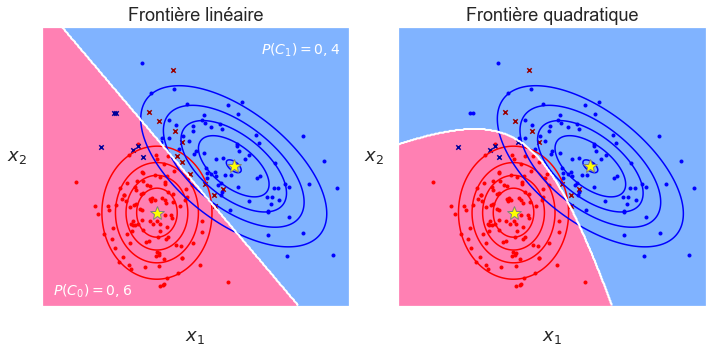

In [3]:
if __name__=='__main__':

    # ------- Paramètres des gaussiennes --------
        
    mu = np.zeros((2,2))
    mu[0,:] = [-1., -1.]
    mu[1,:] = [1., 0.]

    sigma = np.zeros((2,2))
    sigma[0,:] = [.8, .8]
    sigma[1,:] = [1.5, .7]

    angle = np.array([0., -30]) 
    prob_C = np.array([0.6, 0.4]) 

    texte = ['$P(C_{0})=0,6$', '$P(C_{1})=0,4$']
    texte_pos = np.zeros((2,2))
    texte_pos[0,:] = [-3.7, -2.7]
    texte_pos[1,:] = [1.7, 2.5]
    
    x_min, x_max = -4., 4.
    y_min, y_max = -3., 3.
    
    nom_figure = "Figure_26(1)_41.svg"
        
    # ----------- Génération des distributions --------------
    pdf = genere_distributions(mu, sigma, angle, prob_C, x_min, x_max, y_min, y_max)
    
    
    # -----------Affichage des distributions ---------
    # Utiliser la commande suivante pour déterminer les valeurs optimales des paramètres 
    #pdf.affiche_PDF_avec_zones_influence(texte, texte_pos)
        
    # Affichage et sauvegarde des meilleurs résultats
    pdf.affiche_PDF_avec_zones_influence(texte, texte_pos, affiche_tickmarks=False, nom_figure=nom_figure)
    

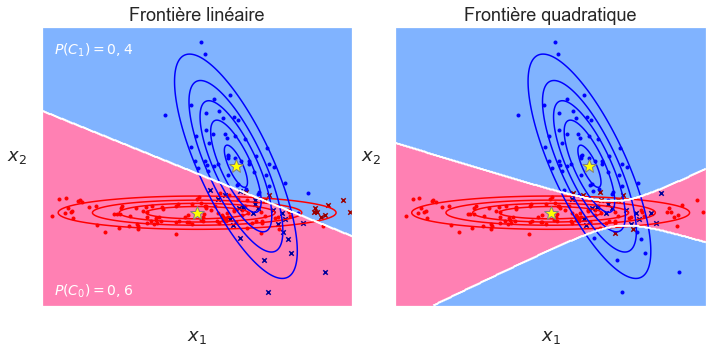

In [4]:
if __name__=='__main__':

    # ------- Paramètres des gaussiennes --------

    mu = np.zeros((2,2))
    mu[0,:] = [0., -1.]
    mu[1,:] = [1., 0.]

    sigma = np.zeros((2,2))
    sigma[0,:] = [2, .2]
    sigma[1,:] = [1.5, .5]

    angle = np.array([0., -60]) 
    prob_C = np.array([0.6, 0.4]) 

    texte = ['$P(C_{0})=0,6$', '$P(C_{1})=0,4$']
    texte_pos = np.zeros((2,2))
    texte_pos[0,:] = [-3.7, -2.7]
    texte_pos[1,:] = [-3.7, 2.5]
    
    x_min, x_max = -4., 4.
    y_min, y_max = -3., 3.
        
    nom_figure = "Figure_26(2)_41.svg"
        
    # ----------- Génération des distributions --------------
    pdf = genere_distributions(mu, sigma, angle, prob_C, x_min, x_max, y_min, y_max)
    
    
    # -----------Affichage des distributions ---------
    # Utiliser la commande suivante pour déterminer les valeurs optimales des paramètres 
    #pdf.affiche_PDF_avec_zones_influence(texte, texte_pos)
        
    # Affichage et sauvegarde des meilleurs résultats
    pdf.affiche_PDF_avec_zones_influence(texte, texte_pos, affiche_tickmarks=False, nom_figure=nom_figure)
    
    

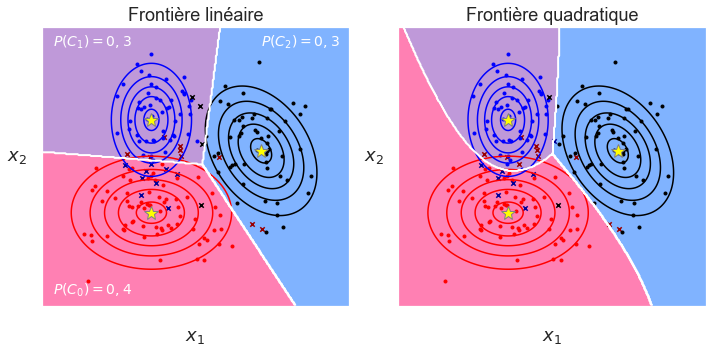

In [5]:
if __name__=='__main__':

    # ------- Paramètres des gaussiennes --------
  
    mu = np.zeros((3,2))
    mu[0,:] = [0., 2.]
    mu[1,:] = [0., 5.]
    mu[2,:] = [5., 4.]

    sigma = np.zeros((3,2))
    sigma[0,:] = [2., 1.]
    sigma[1,:] = [1., 1.]
    sigma[2,:] = [1., 1.5]

    angle = np.array([0., 0., 60]) 
    prob_C = np.array([0.4, 0.3, 0.3]) 

    texte = ['$P(C_{0})=0,4$', '$P(C_{1})=0,3$', '$P(C_{2})=0,3$']
    texte_pos = np.zeros((3,2))
    texte_pos[0,:] = [-4.5, -.5]
    texte_pos[1,:] = [-4.5, 7.5]
    texte_pos[2,:] = [5., 7.5]    
    
    x_min, x_max = -5., 9.
    y_min, y_max = -1., 8.
        
    nom_figure = "Figure_27_41.svg"
        
    # ----------- Génération des distributions --------------
    pdf = genere_distributions(mu, sigma, angle, prob_C, x_min, x_max, y_min, y_max)
    
    
    # -----------Affichage des distributions ---------
    # Utiliser la commande suivante pour déterminer les valeurs optimales des paramètres 
    #pdf.affiche_PDF_avec_zones_influence(texte, texte_pos)
        
    # Affichage et sauvegarde des meilleurs résultats
    pdf.affiche_PDF_avec_zones_influence(texte, texte_pos, affiche_tickmarks=False, nom_figure=nom_figure)
    
    